# Chunk Detection

## PySpark setup

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, IntegerType, DoubleType, LongType

spark = SparkSession \
    .builder \
    .config("spark.driver.memory", '4G') \
    .config("spark.ui.killEnabled", False) \
    .getOrCreate()
spark.sparkContext.setLogLevel('OFF')

22/05/10 00:05:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/10 00:05:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df = spark.read.parquet("data/0.parquet").cache()

In [4]:
df.show(n=5)

+-------------------+-------------+-----+-------------+-----+------+--------+---------+-------+-------+------------+---------------+------+
|                 ts|          sIP|sPort|          dIP|dPort|ip_len|ip_proto|tcp_flags|tcp_seq|tcp_ack|tls_hostname|   dns_hostname|dns_ip|
+-------------------+-------------+-----+-------------+-----+------+--------+---------+-------+-------+------------+---------------+------+
|1.651792537098148E9|192.168.1.138|38911|  128.111.1.1|   53|    72|      17|     null|   null|   null|        null|         <Root>|  null|
|1.651792537100018E9|  128.111.1.1|   53|192.168.1.138|38911|   123|      17|     null|   null|   null|        null|ucsb.edu,<Root>|  null|
|1.651792537100137E9|192.168.1.138|38911|  128.111.1.1|   53|    61|      17|     null|   null|   null|        null|           null|  null|
|1.651792537101463E9|  128.111.1.1|   53|192.168.1.138|38911|   112|      17|     null|   null|   null|        null|       ucsb.edu|  null|
|1.651792537102078E9

In [5]:
df.count()

21342

## googlevideo traffic

googlevideo.com is the domain owned by google used to store videos for YouTube.

In [6]:
df.select('dns_ip', 'dns_hostname').distinct().filter(
    df.dns_hostname.contains('googlevideo')).show(truncate=False)

+-------------+----------------------------------------------------------------------------+
|dns_ip       |dns_hostname                                                                |
+-------------+----------------------------------------------------------------------------+
|198.189.66.16|rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxopj-n5oe.googlevideo.com,<Root>|
|198.189.66.17|r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj-n5oe.googlevideo.com,<Root>  |
|null         |rr5---sn-jxopj-n5oe.googlevideo.com,rr5.sn-jxopj-n5oe.googlevideo.com,<Root>|
|null         |r6.sn-jxopj-n5oe.googlevideo.com,<Root>                                     |
|null         |rr5.sn-jxopj-n5oe.googlevideo.com,<Root>                                    |
|198.189.66.16|rr5.sn-jxopj-n5oe.googlevideo.com,<Root>                                    |
|198.189.66.17|r6.sn-jxopj-n5oe.googlevideo.com,<Root>                                     |
|null         |r6---sn-jxopj-n5oe.googlevideo.com,r6.sn-jxopj-n5oe.goo

In [7]:
df.select('sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname'
         ).filter(df.tls_hostname.contains('googlevideo')).show(truncate=False)

+-------------+-----+-------------+-----+--------+-----------------------------------+
|sIP          |sPort|dIP          |dPort|ip_proto|tls_hostname                       |
+-------------+-----+-------------+-----+--------+-----------------------------------+
|192.168.1.138|39718|198.189.66.17|443  |17      |r6---sn-jxopj-n5oe.googlevideo.com |
|192.168.1.138|50222|198.189.66.16|443  |17      |rr5---sn-jxopj-n5oe.googlevideo.com|
|192.168.1.138|43937|198.189.66.16|443  |17      |rr5---sn-jxopj-n5oe.googlevideo.com|
|192.168.1.138|41402|198.189.66.17|443  |6       |r6---sn-jxopj-n5oe.googlevideo.com |
|192.168.1.138|41404|198.189.66.17|443  |6       |r6---sn-jxopj-n5oe.googlevideo.com |
|192.168.1.138|46564|198.189.66.16|443  |6       |rr5---sn-jxopj-n5oe.googlevideo.com|
|192.168.1.138|46566|198.189.66.16|443  |6       |rr5---sn-jxopj-n5oe.googlevideo.com|
+-------------+-----+-------------+-----+--------+-----------------------------------+



## Wireshark Conversations

Open statistics $\rightarrow$ Conversations from the Wireshark menu. Click on IPv4 to see the chunks transported over all transport layer protocols (TCP, QUIC, UDP). Then, click on Bytes to sort the rows in descending order by Bytes (IPv4 Total length field).

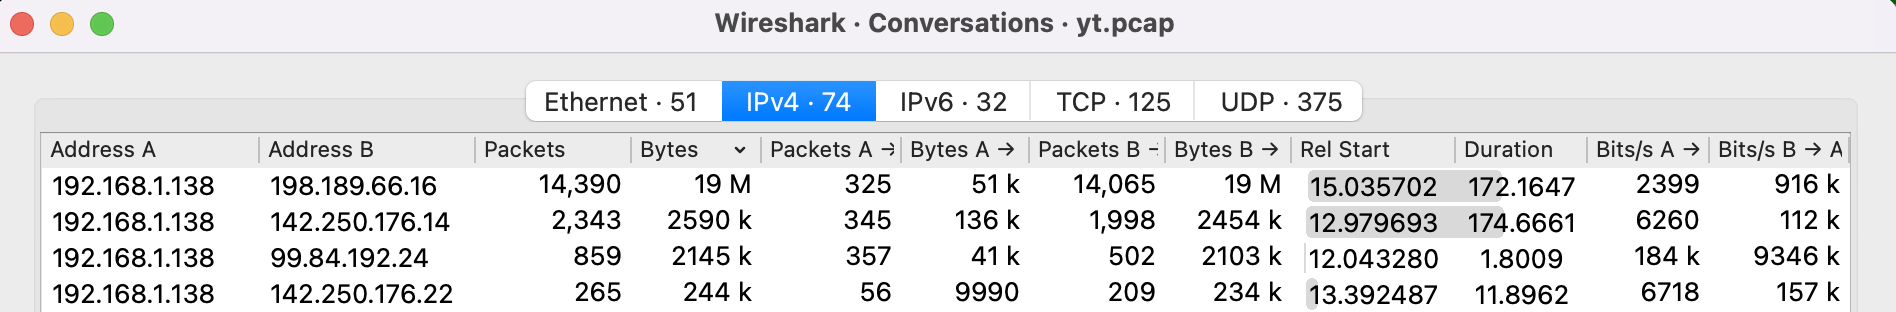

### Other interesting queries

**Query 1**: Source IP addresses along with the number of packets and the bytes (in B) they transferred.

In [8]:
df.groupby('sIP').agg({'ip_len': 'sum', '*': 'count'}).sort('sum(ip_len)', ascending=False).show(n=7)

+--------------+--------+-----------+
|           sIP|count(1)|sum(ip_len)|
+--------------+--------+-----------+
| 198.189.66.16|   14065|   19530980|
|142.250.176.14|    1998|    2426225|
|  99.84.192.24|     502|    2096701|
| 192.168.1.138|    2933|     437931|
|142.250.176.22|     209|     231296|
| 142.250.68.33|      52|     119359|
|142.250.72.227|      65|      70760|
+--------------+--------+-----------+
only showing top 7 rows



We see that the googlevideo IP `198.189.66.16` sends over 19.5 Mb of data

**Query 2**: Destination IP addresses along with the number of packets and the bytes (in B) transferred to them.

In [9]:
df.groupby('dIP').agg({'ip_len': 'sum', '*': 'count'}).sort('sum(ip_len)', ascending=False).show(n=7)

+--------------+--------+-----------+
|           dIP|count(1)|sum(ip_len)|
+--------------+--------+-----------+
| 192.168.1.138|   18407|   24957142|
|142.250.176.14|     345|     131859|
| 128.111.52.93|     687|      61452|
| 198.189.66.16|     325|      47090|
|  99.84.192.24|     357|      36608|
|   192.168.1.1|     175|      14099|
|142.250.72.138|      58|      12510|
+--------------+--------+-----------+
only showing top 7 rows



We see that the Host IP address `192.168.1.138` receives around 25 Mb of data from various sources

**Query 3**: `142.250.176.14` is the second most prominent IP address in both queries 1 and 2. Let's see what hostname this IP belongs to

In [10]:
df.select('sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname'
         ).filter((df.dIP == '142.250.176.14') & (df.tls_hostname.isNotNull())).show(truncate=False)

+-------------+-----+--------------+-----+--------+---------------+
|sIP          |sPort|dIP           |dPort|ip_proto|tls_hostname   |
+-------------+-----+--------------+-----+--------+---------------+
|192.168.1.138|41465|142.250.176.14|443  |17      |www.youtube.com|
|192.168.1.138|55745|142.250.176.14|443  |17      |www.youtube.com|
|192.168.1.138|55104|142.250.176.14|443  |6       |www.youtube.com|
|192.168.1.138|57212|142.250.176.14|443  |6       |www.youtube.com|
|192.168.1.138|57214|142.250.176.14|443  |6       |www.youtube.com|
|192.168.1.138|57216|142.250.176.14|443  |6       |www.youtube.com|
+-------------+-----+--------------+-----+--------+---------------+



**Query 4**: `99.84.192.24` ranks as the third most prominent source IP address which sends 2.1 Mb of data. Let's find out the hostname for this address

In [11]:
df.select('sIP', 'sPort', 'dIP', 'dPort', 'ip_proto', 'tls_hostname'
         ).filter((df.dIP == '99.84.192.24') & (df.tls_hostname.isNotNull())).show(truncate=False)

+-------------+-----+------------+-----+--------+-----------------------------------+
|sIP          |sPort|dIP         |dPort|ip_proto|tls_hostname                       |
+-------------+-----+------------+-----+--------+-----------------------------------+
|192.168.1.138|38066|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38070|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38072|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38074|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38078|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38080|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38084|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38086|99.84.192.24|443  |6       |tracking-protection.cdn.mozilla.net|
|192.168.1.138|38088|99.84.192.24|443  |6       |track

We can also use DNS responses for running query 3. But, we see lines of IP addresses. A DNS response may return multiple answers for a query (hostname). Each answer resolves the query into an IP address. Further, the response may also include a [CNAME record][1] which gives an alias of the query hostname.

[1]: https://en.wikipedia.org/wiki/CNAME_record

In [12]:
df.select('dns_ip', 'dns_hostname').distinct().filter(df.dns_ip.contains('99.84.192.24')).show(truncate=False)

+---------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|dns_ip                                             |dns_hostname                                                                                                                                                      |
+---------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|99.84.192.27,99.84.192.91,99.84.192.81,99.84.192.24|tracking-protection.cdn.mozilla.net,d1zkz3k4cclnv6.cloudfront.net,d1zkz3k4cclnv6.cloudfront.net,d1zkz3k4cclnv6.cloudfront.net,d1zkz3k4cclnv6.cloudfront.net,<Root>|
|99.84.192.91,99.84.192.27,99.84.192.24,99.84.192.81|d1zkz3k4cclnv6.cloudfront.net,d1zkz3k4cclnv6.cloudfront.net,d1zkz3k4cclnv6.clou

Instead, we can use the function below to give a simpler output!

In [13]:
def resolve_ip_from_dns(ip_str):
    rows = df.select('dns_hostname').distinct().filter(df.dns_ip.contains(ip_str)).collect()
    result = []
    for row in rows:
        hostname_list = row.dns_hostname.split(',')
        result.extend(hostname_list)
    return set(result) - {'<Root>'}

In [14]:
resolve_ip_from_dns('142.250.176.14')

{'www.youtube.com', 'youtube-ui.l.google.com'}

In [15]:
resolve_ip_from_dns('99.84.192.24')

{'d1zkz3k4cclnv6.cloudfront.net', 'tracking-protection.cdn.mozilla.net'}

## Isolating a flow for the video streaming session

A video streaming session consists of multiple flows. Let's isolate the biggest flow

In [16]:
df.filter((df.sIP=='198.189.66.16') & (df.dIP == '192.168.1.138')).groupby(
    'sIP', 'sPort', 'dIP', 'dPort', 'ip_proto').agg(
    {'ip_len': 'sum', '*': 'count'}).sort(
    'sum(ip_len)', ascending=False).show(n=7)

+-------------+-----+-------------+-----+--------+--------+-----------+
|          sIP|sPort|          dIP|dPort|ip_proto|count(1)|sum(ip_len)|
+-------------+-----+-------------+-----+--------+--------+-----------+
|198.189.66.16|  443|192.168.1.138|50222|      17|   12148|   16753168|
|198.189.66.16|  443|192.168.1.138|43937|      17|    1811|    2500427|
|198.189.66.16|  443|192.168.1.138|46564|       6|      70|     202465|
|198.189.66.16|  443|192.168.1.138|46566|       6|      36|      74920|
+-------------+-----+-------------+-----+--------+--------+-----------+



## Constants and Functions

In [17]:
HOST_IP = "192.168.1.138"
YOUTUBE_IP = "198.189.66.16"
HOST_PORT = 50222
YOUTUBE_PORT = 443
TRANSPORT_PROTO = 17
GET_thresh = 300
DOWN_thresh = 300
VIDEO_thresh = 1000

In [18]:
flow_df = df.filter((((df.sIP == YOUTUBE_IP) & (df.dIP == HOST_IP) & 
                      (df.sPort == YOUTUBE_PORT) & (df.dPort == HOST_PORT)) | 
                     ((df.sIP == HOST_IP) & (df.dIP == YOUTUBE_IP) & 
                      (df.sPort == HOST_PORT) & (df.dPort == YOUTUBE_PORT))) &
                    (df.ip_proto == TRANSPORT_PROTO)) \
            .sort('ts')
# flow_df = flow_df.withColumn('ts', flow_df['ts'] - flow_df.agg({'ts': 'min'}).collect()[0]['min(ts)'])
flow_df = flow_df.withColumn('idx', F.row_number().over(Window().orderBy('ts')))
flow_df = flow_df.cache()

In [19]:
flow_df.show(n=3)

+-------------------+-------------+-----+-------------+-----+------+--------+---------+-------+-------+--------------------+------------+------+---+
|                 ts|          sIP|sPort|          dIP|dPort|ip_len|ip_proto|tcp_flags|tcp_seq|tcp_ack|        tls_hostname|dns_hostname|dns_ip|idx|
+-------------------+-------------+-----+-------------+-----+------+--------+---------+-------+-------+--------------------+------------+------+---+
|1.651792545959912E9|192.168.1.138|50222|198.189.66.16|  443|  1385|      17|     null|   null|   null|rr5---sn-jxopj-n5...|        null|  null|  1|
|1.651792545968033E9|198.189.66.16|  443|192.168.1.138|50222|  1385|      17|     null|   null|   null|                null|        null|  null|  2|
|1.651792545968036E9|198.189.66.16|  443|192.168.1.138|50222|  1385|      17|     null|   null|   null|                null|        null|  null|  3|
+-------------------+-------------+-----+-------------+-----+------+--------+---------+-------+-------+---

## Chunk Detection Algorithm

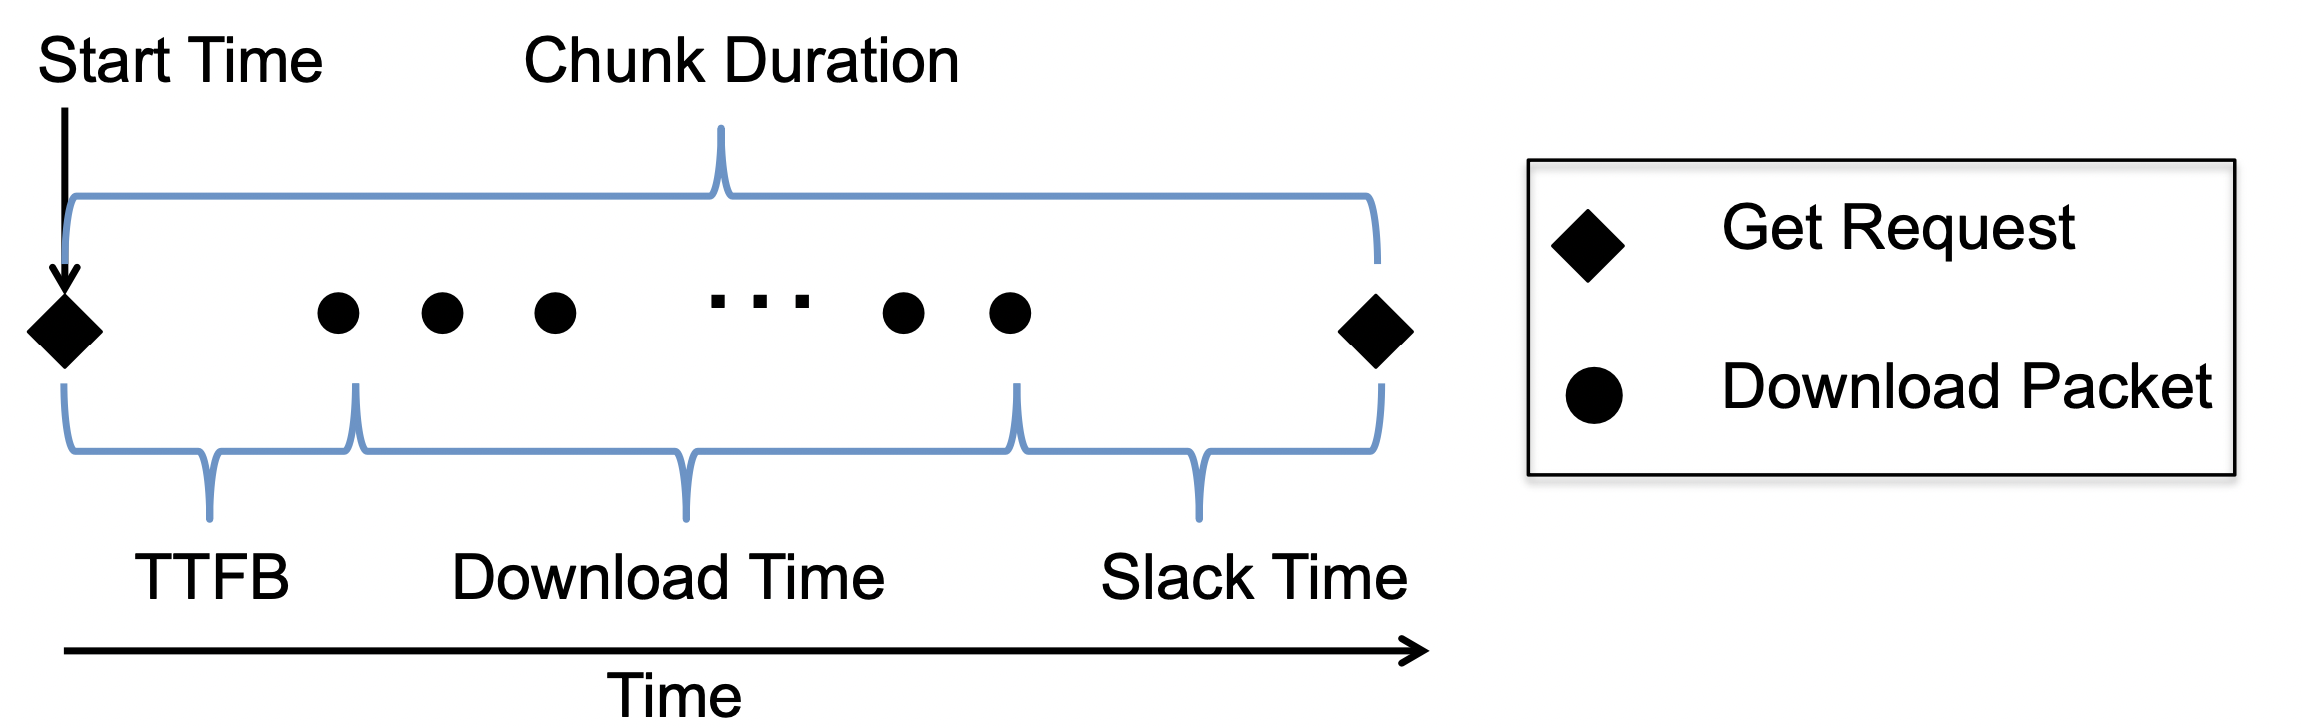

Credits: Requet: Real-Time QoE Detection for Encrypted YouTube Traffic (mmsys'19)

In [20]:
def get_request_indices():
    get_req_idx_df = flow_df.filter((flow_df.sIP == HOST_IP) & 
                                    (flow_df.dIP == YOUTUBE_IP) & 
                                    (flow_df.ip_len > GET_thresh) &
                                    (flow_df.ip_len > VIDEO_thresh)
                                   ).select('idx', 'ts')
    return [(r.idx, r.ts) for r in get_req_idx_df.collect()]


def chunk_detection():
    indices = get_request_indices()
    chunk_stats = []
    for i in range(len(indices)):
        curr_idx, curr_get_req_time = indices[i]
        next_idx, next_get_req_time = (None, None) if i == len(indices) - 1 else indices[i+1]
        curr_chunk_df = flow_df.filter((flow_df.sIP == YOUTUBE_IP) &
                                       (flow_df.dIP == HOST_IP) &
                                       (flow_df.idx > curr_idx) &
                                       (flow_df.ip_len > DOWN_thresh))
        if next_idx is not None:
            curr_chunk_df = curr_chunk_df.filter(curr_chunk_df.idx < next_idx)
            
        chunk_size = curr_chunk_df.agg({'ip_len': 'sum'}).collect()[0]['sum(ip_len)']
        if chunk_size < 80000:
            continue
        
#         curr_chunk_df = curr_chunk_df.withColumn('time_since_request', curr_chunk_df.ts - curr_get_req_time)
        first_pkt_download_time = curr_chunk_df.agg({'ts': 'min'}).collect()[0]['min(ts)']
        last_pkt_download_time = curr_chunk_df.agg({'ts': 'max'}).collect()[0]['max(ts)']
        ttfb = first_pkt_download_time - curr_get_req_time
        chunk_stats.append({'ttfb': ttfb, 'chunk_size': chunk_size, 
                            'last_get_req_time': curr_get_req_time,
                            'next_get_req_time': next_get_req_time,
                            'first_pkt_download_time': first_pkt_download_time,
                            'last_pkt_download_time': last_pkt_download_time,
                            'download_time': last_pkt_download_time - first_pkt_download_time
                           })
    return chunk_stats


chunk_data = chunk_detection()

In [21]:
chunk_data

[{'ttfb': 0.031063079833984375,
  'chunk_size': 598825,
  'last_get_req_time': 1651792552.057679,
  'next_get_req_time': 1651792552.342599,
  'first_pkt_download_time': 1651792552.088742,
  'last_pkt_download_time': 1651792552.271646,
  'download_time': 0.18290400505065918},
 {'ttfb': 0.006278038024902344,
  'chunk_size': 1123995,
  'last_get_req_time': 1651792552.342599,
  'next_get_req_time': 1651792561.149411,
  'first_pkt_download_time': 1651792552.348877,
  'last_pkt_download_time': 1651792554.217295,
  'download_time': 1.8684179782867432},
 {'ttfb': 0.006098031997680664,
  'chunk_size': 1823901,
  'last_get_req_time': 1651792561.149411,
  'next_get_req_time': 1651792564.172633,
  'first_pkt_download_time': 1651792561.155509,
  'last_pkt_download_time': 1651792561.441184,
  'download_time': 0.285675048828125},
 {'ttfb': 0.005983114242553711,
  'chunk_size': 357998,
  'last_get_req_time': 1651792564.172633,
  'next_get_req_time': 1651792577.095794,
  'first_pkt_download_time': 1651

### Plotting

In [22]:
def change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=False, is_y_log=False):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if is_x_log:
        ax.set_xscale('log')
    if is_y_log:
        ax.set_yscale('log')
    if Xmin is not None:
        ax.set_xlim(xmin=Xmin)
    if Xmax is not None:
        ax.set_xlim(xmax=Xmax)
    ax.grid(True)
    return

def get_color_and_linestyle_kwargs(i):
    color_n = ['r', 'b', 'k', 'g', 'm', 'c', 'y']
    linestyles = ['-', '--', ':', '-.']
    return {'color': color_n[i % len(color_n)], 'linestyle': linestyles[i % len(linestyles)]}

def plotCDF(ax, data, labels, xlabel, ylabel, Xmax=None, Xmin=None, log_scale=False,
            set_legend=True, color_n_linestyle_dicts=None):
    raw = {}
    markers = ['o', '*', '^', '1', '4', 's', 'd', '3', 'd', 'o', '*', '^']

    for key in sorted(labels):
        raw[key] = list(data[key])
        if len(raw[key]) == 0:
            continue

        elms, cts = np.unique(raw[key], return_counts=True)
        cdf = np.cumsum(cts)
        cdf = cdf / cdf[-1]
        kwargs_dict = (get_color_and_linestyle_kwargs(key) if color_n_linestyle_dicts is None
                       else color_n_linestyle_dicts[key])
        ax.step(list(elms[:1]) + list(elms), [0] + list(cdf), where='post',
                label=labels[key], **kwargs_dict)

    # pl.legend((p),legnd,'lower right')
    if len(labels) > 1 and set_legend:
        set_legend_to_right(ax)

    change_plot_params(ax, xlabel, ylabel, Xmin, Xmax, is_x_log=log_scale)
    ax.set_ylim(ymax=1.0)
    ax.set_ylim(ymin=0.0)

In [23]:
ttfb_data = [x['ttfb'] * 1000 for x in chunk_data]

#### Cumulative Distribution Function (CDF)

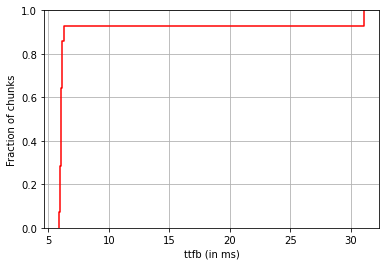

In [24]:
plotCDF(plt.gca(), {0: ttfb_data}, {0: ''}, 'ttfb (in ms)', 'Fraction of chunks')
plt.show()

### Line plot

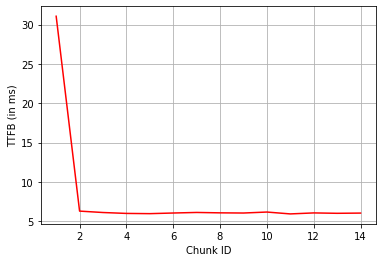

In [25]:
def line_plot():
    chunk_ids = range(1, 1 + len(chunk_data))
    plt.plot(chunk_ids, ttfb_data, **get_color_and_linestyle_kwargs(0))
    change_plot_params(plt.gca(), 'Chunk ID', 'TTFB (in ms)', None, None, is_x_log=False, is_y_log=False)
    return

line_plot()
plt.show()

## YouTube stats for nerds data

In [26]:
sfn_df = spark.read.option("header", "true").csv("yt-stats.csv").cache()
sfn_df = sfn_df.withColumn("buffer_health", sfn_df["buffer_health"].cast(DoubleType()))
sfn_df = sfn_df.withColumn("playback_progress", sfn_df["playback_progress"].cast(DoubleType()))
sfn_df = sfn_df.withColumn("ts", sfn_df["timestamp"].cast(DoubleType()))
sfn_df = sfn_df.drop('timestamp')
sfn_df.show(n=5)

+--------------------+--------------------+-------------+-----+-----------------+--------------------+
|     viewport_frames| current_optimal_res|buffer_health|state|playback_progress|                  ts|
+--------------------+--------------------+-------------+-----+-----------------+--------------------+
|         794x447 / -| 854x480@30 / 854...|        25.33|  44c|              0.0|1.6517925614212017E9|
|         794x447 / -| 854x480@30 / 854...|        25.33|  44c|              0.0|1.6517925624655404E9|
|         794x447 / -| 854x480@30 / 854...|        25.33|  44c|              0.0|1.6517925642902136E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        25.42|    8|             4.58|1.6517925651281989E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        25.42|    8|             4.58|1.6517925652358367E9|
+--------------------+--------------------+-------------+-----+-----------------+--------------------+
only showing top 5 rows



In [27]:
sfn_df.groupBy('viewport_frames', 'current_optimal_res', 
               'buffer_health', 'state', 'playback_progress').agg({'ts': 'min'}).sort('min(ts)').show()

+--------------------+--------------------+-------------+-----+-----------------+--------------------+
|     viewport_frames| current_optimal_res|buffer_health|state|playback_progress|             min(ts)|
+--------------------+--------------------+-------------+-----+-----------------+--------------------+
|         794x447 / -| 854x480@30 / 854...|        25.33|  44c|              0.0|1.6517925614212017E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        25.42|    8|             4.58|1.6517925651281989E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        35.18|    8|             5.56| 1.651792565295063E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        43.99|    8|             6.09|1.6517925657776096E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|         43.5|    8|             6.62|1.6517925663283267E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        42.44|    8|             7.56| 1.651792567734878E9|
| 794x447 / 0 drop...| 854x480@30 / 854...|        42.16|    4|          